In [1]:
import os, json, sys, time, random
import numpy as np
import torch
from  easydict import EasyDict
from math import floor
from easydict import EasyDict

from steves_utils.vanilla_train_eval_test_jig import  Vanilla_Train_Eval_Test_Jig

from steves_utils.torch_utils import get_dataset_metrics, independent_accuracy_assesment
from steves_models.configurable_vanilla import Configurable_Vanilla
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.lazy_map import Lazy_Map
from steves_utils.sequence_aggregator import Sequence_Aggregator

from steves_utils.stratified_dataset.traditional_accessor import Traditional_Accessor_Factory

from steves_utils.cnn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.torch_utils import (
    confusion_by_domain_over_dataloader,
    independent_accuracy_assesment
)

from steves_utils.utils_v2 import (
    per_domain_accuracy_from_confusion,
    get_datasets_base_path
)

# from steves_utils.ptn_do_report import TBD

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "dataset_seed",
    "seed",
    "labels",
    "domains_target",
    "domains_source",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "batch_size",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "normalize_source",
    "normalize_target",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "pickle_name_source",
    "pickle_name_target",
    "torch_default_dtype",
}

In [3]:
from steves_utils.ORACLE.utils_v2 import (
    ALL_SERIAL_NUMBERS,
    ALL_DISTANCES_FEET_NARROWED,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "MANUAL CORES CNN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["dataset_seed"] = 1337
standalone_parameters["seed"] = 1337
standalone_parameters["labels"] = ALL_SERIAL_NUMBERS

standalone_parameters["domains_source"] = [8,32,50]
standalone_parameters["domains_target"] = [14,20,26,38,44,]

standalone_parameters["num_examples_per_domain_per_label_source"]=-1
standalone_parameters["num_examples_per_domain_per_label_target"]=-1

standalone_parameters["pickle_name_source"] = "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"
standalone_parameters["pickle_name_target"] = "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"

standalone_parameters["torch_default_dtype"] = "torch.float32" 

standalone_parameters["batch_size"]=128

standalone_parameters["n_epoch"] = 3

standalone_parameters["patience"] = 10

standalone_parameters["criteria_for_best"] = "target_accuracy"
standalone_parameters["normalize_source"] = False
standalone_parameters["normalize_target"] = False

standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": len(standalone_parameters["labels"])}},
]

standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

In [4]:
# Parameters
parameters = {
    "experiment_name": "cnn_2:oracle.run2.framed",
    "labels": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "domains_source": [8, 32, 50, 14, 20, 26, 38, 44],
    "domains_target": [8, 32, 50, 14, 20, 26, 38, 44],
    "pickle_name_source": "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl",
    "pickle_name_target": "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl",
    "device": "cuda",
    "lr": 0.0001,
    "batch_size": 128,
    "normalize_source": False,
    "normalize_target": False,
    "num_examples_per_domain_per_label_source": -1,
    "num_examples_per_domain_per_label_target": -1,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 16}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "dataset_seed": 500,
    "seed": 500,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
def wrap_in_dataloader(p, ds):
    return torch.utils.data.DataLoader(
        ds,
        batch_size=p.batch_size,
        shuffle=True,
        num_workers=1,
        persistent_workers=True,
        prefetch_factor=50,
        pin_memory=True
    )

taf_source = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_source),
    seed=p.dataset_seed
)
train_original_source, val_original_source, test_original_source = \
    taf_source.get_train(), taf_source.get_val(), taf_source.get_test()


taf_target = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_target),
    seed=p.dataset_seed
)
train_original_target, val_original_target, test_original_target = \
    taf_target.get_train(), taf_target.get_val(), taf_target.get_test()


# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Map. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[:2] # Strip the tuple to just (x,y)


train_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_source, transform_lambda)
)
val_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_source, transform_lambda)
)
test_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_source, transform_lambda)
)

train_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_target, transform_lambda)
)
val_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_target, transform_lambda)
)
test_processed_target  = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_target, transform_lambda)
)



datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
ep = next(iter(test_processed_target))
ep[0].dtype

torch.float32

In [12]:
model = Configurable_Vanilla(
    x_net=x_net,
    label_loss_object=torch.nn.NLLLoss(),
    learning_rate=p.lr
)

In [13]:
jig = Vanilla_Train_Eval_Test_Jig(
    model=model,
    path_to_best_model=p.BEST_MODEL_PATH,
    device=p.device,
    label_loss_object=torch.nn.NLLLoss(),
)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    patience=p.patience,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    criteria_for_best=p.criteria_for_best
)

epoch: 1, [batch: 1 / 1400], examples_per_second: 696.5474, train_label_loss: 2.8232, 


epoch: 1, [batch: 140 / 1400], examples_per_second: 10431.5341, train_label_loss: 2.6887, 


epoch: 1, [batch: 280 / 1400], examples_per_second: 10658.1067, train_label_loss: 2.6085, 


epoch: 1, [batch: 420 / 1400], examples_per_second: 10637.7787, train_label_loss: 2.5075, 


epoch: 1, [batch: 560 / 1400], examples_per_second: 10494.6588, train_label_loss: 2.3305, 


epoch: 1, [batch: 700 / 1400], examples_per_second: 10656.8766, train_label_loss: 2.1909, 


epoch: 1, [batch: 840 / 1400], examples_per_second: 10532.9349, train_label_loss: 2.0089, 


epoch: 1, [batch: 980 / 1400], examples_per_second: 10637.2699, train_label_loss: 1.7954, 


epoch: 1, [batch: 1120 / 1400], examples_per_second: 10635.2981, train_label_loss: 1.8543, 


epoch: 1, [batch: 1260 / 1400], examples_per_second: 10512.9208, train_label_loss: 1.5110, 


epoch: 1, source_val_acc_label: 0.5526, source_val_label_loss: 1.5012, target_val_acc_label: 0.5526, target_val_label_loss: 1.5012, 


New best
epoch: 2, [batch: 1 / 1400], examples_per_second: 48.0950, train_label_loss: 1.4000, 


epoch: 2, [batch: 140 / 1400], examples_per_second: 10407.1376, train_label_loss: 1.4392, 


epoch: 2, [batch: 280 / 1400], examples_per_second: 10516.0244, train_label_loss: 1.3398, 


epoch: 2, [batch: 420 / 1400], examples_per_second: 10550.0701, train_label_loss: 1.3207, 


epoch: 2, [batch: 560 / 1400], examples_per_second: 10598.8549, train_label_loss: 1.1353, 


epoch: 2, [batch: 700 / 1400], examples_per_second: 10636.8333, train_label_loss: 1.1747, 


epoch: 2, [batch: 840 / 1400], examples_per_second: 10683.3832, train_label_loss: 0.9638, 


epoch: 2, [batch: 980 / 1400], examples_per_second: 10574.1340, train_label_loss: 0.9117, 


epoch: 2, [batch: 1120 / 1400], examples_per_second: 10645.1582, train_label_loss: 0.8757, 


epoch: 2, [batch: 1260 / 1400], examples_per_second: 10684.5739, train_label_loss: 0.9401, 


epoch: 2, source_val_acc_label: 0.8214, source_val_label_loss: 0.7312, target_val_acc_label: 0.8214, target_val_label_loss: 0.7312, 


New best
epoch: 3, [batch: 1 / 1400], examples_per_second: 56.8160, train_label_loss: 0.6620, 


epoch: 3, [batch: 140 / 1400], examples_per_second: 10512.0194, train_label_loss: 0.6873, 


epoch: 3, [batch: 280 / 1400], examples_per_second: 10530.4601, train_label_loss: 0.5378, 


epoch: 3, [batch: 420 / 1400], examples_per_second: 10485.0052, train_label_loss: 0.5843, 


epoch: 3, [batch: 560 / 1400], examples_per_second: 10518.0051, train_label_loss: 0.6385, 


epoch: 3, [batch: 700 / 1400], examples_per_second: 10589.2101, train_label_loss: 0.5095, 


epoch: 3, [batch: 840 / 1400], examples_per_second: 10625.9881, train_label_loss: 0.6784, 


epoch: 3, [batch: 980 / 1400], examples_per_second: 10575.8584, train_label_loss: 0.5748, 


epoch: 3, [batch: 1120 / 1400], examples_per_second: 10446.9744, train_label_loss: 0.3375, 


epoch: 3, [batch: 1260 / 1400], examples_per_second: 10492.4686, train_label_loss: 0.3713, 


epoch: 3, source_val_acc_label: 0.8959, source_val_label_loss: 0.4234, target_val_acc_label: 0.8959, target_val_label_loss: 0.4234, 


New best
epoch: 4, [batch: 1 / 1400], examples_per_second: 57.0091, train_label_loss: 0.4422, 


epoch: 4, [batch: 140 / 1400], examples_per_second: 10517.4418, train_label_loss: 0.3962, 


epoch: 4, [batch: 280 / 1400], examples_per_second: 10508.0941, train_label_loss: 0.5385, 


epoch: 4, [batch: 420 / 1400], examples_per_second: 10648.0642, train_label_loss: 0.5160, 


epoch: 4, [batch: 560 / 1400], examples_per_second: 10614.0481, train_label_loss: 0.4116, 


epoch: 4, [batch: 700 / 1400], examples_per_second: 10506.8925, train_label_loss: 0.3972, 


epoch: 4, [batch: 840 / 1400], examples_per_second: 10519.6392, train_label_loss: 0.5987, 


epoch: 4, [batch: 980 / 1400], examples_per_second: 10510.0146, train_label_loss: 0.3704, 


epoch: 4, [batch: 1120 / 1400], examples_per_second: 10600.4693, train_label_loss: 0.3355, 


epoch: 4, [batch: 1260 / 1400], examples_per_second: 10573.9049, train_label_loss: 0.4161, 


epoch: 4, source_val_acc_label: 0.9312, source_val_label_loss: 0.2816, target_val_acc_label: 0.9312, target_val_label_loss: 0.2816, 


New best
epoch: 5, [batch: 1 / 1400], examples_per_second: 57.2392, train_label_loss: 0.3070, 


epoch: 5, [batch: 140 / 1400], examples_per_second: 10536.8690, train_label_loss: 0.2629, 


epoch: 5, [batch: 280 / 1400], examples_per_second: 10628.7364, train_label_loss: 0.2499, 


epoch: 5, [batch: 420 / 1400], examples_per_second: 10658.7853, train_label_loss: 0.1948, 


epoch: 5, [batch: 560 / 1400], examples_per_second: 10659.3340, train_label_loss: 0.2899, 


epoch: 5, [batch: 700 / 1400], examples_per_second: 10628.6387, train_label_loss: 0.2688, 


epoch: 5, [batch: 840 / 1400], examples_per_second: 10683.9162, train_label_loss: 0.2659, 


epoch: 5, [batch: 980 / 1400], examples_per_second: 10654.5834, train_label_loss: 0.2063, 


epoch: 5, [batch: 1120 / 1400], examples_per_second: 10647.2633, train_label_loss: 0.1648, 


epoch: 5, [batch: 1260 / 1400], examples_per_second: 10664.3355, train_label_loss: 0.2653, 


epoch: 5, source_val_acc_label: 0.9377, source_val_label_loss: 0.2246, target_val_acc_label: 0.9377, target_val_label_loss: 0.2246, 


New best
epoch: 6, [batch: 1 / 1400], examples_per_second: 56.5296, train_label_loss: 0.2082, 


epoch: 6, [batch: 140 / 1400], examples_per_second: 10663.6579, train_label_loss: 0.2334, 


epoch: 6, [batch: 280 / 1400], examples_per_second: 10651.9470, train_label_loss: 0.1718, 


epoch: 6, [batch: 420 / 1400], examples_per_second: 10664.3749, train_label_loss: 0.1930, 


epoch: 6, [batch: 560 / 1400], examples_per_second: 10652.9163, train_label_loss: 0.1675, 


epoch: 6, [batch: 700 / 1400], examples_per_second: 10824.6370, train_label_loss: 0.3244, 


epoch: 6, [batch: 840 / 1400], examples_per_second: 10652.2716, train_label_loss: 0.2626, 


epoch: 6, [batch: 980 / 1400], examples_per_second: 10565.6955, train_label_loss: 0.2499, 


epoch: 6, [batch: 1120 / 1400], examples_per_second: 10654.9701, train_label_loss: 0.2346, 


epoch: 6, [batch: 1260 / 1400], examples_per_second: 10647.7188, train_label_loss: 0.1810, 


epoch: 6, source_val_acc_label: 0.9427, source_val_label_loss: 0.2013, target_val_acc_label: 0.9427, target_val_label_loss: 0.2013, 


New best
epoch: 7, [batch: 1 / 1400], examples_per_second: 56.4295, train_label_loss: 0.1507, 


epoch: 7, [batch: 140 / 1400], examples_per_second: 10587.6405, train_label_loss: 0.2318, 


epoch: 7, [batch: 280 / 1400], examples_per_second: 10683.0795, train_label_loss: 0.1743, 


epoch: 7, [batch: 420 / 1400], examples_per_second: 10647.7248, train_label_loss: 0.2462, 


epoch: 7, [batch: 560 / 1400], examples_per_second: 10568.3102, train_label_loss: 0.2070, 


epoch: 7, [batch: 700 / 1400], examples_per_second: 10625.4818, train_label_loss: 0.1864, 


epoch: 7, [batch: 840 / 1400], examples_per_second: 10618.0531, train_label_loss: 0.3154, 


epoch: 7, [batch: 980 / 1400], examples_per_second: 10627.4815, train_label_loss: 0.1624, 


epoch: 7, [batch: 1120 / 1400], examples_per_second: 10648.7823, train_label_loss: 0.1560, 


epoch: 7, [batch: 1260 / 1400], examples_per_second: 10587.3128, train_label_loss: 0.1919, 


epoch: 7, source_val_acc_label: 0.9453, source_val_label_loss: 0.1804, target_val_acc_label: 0.9453, target_val_label_loss: 0.1804, 


New best
epoch: 8, [batch: 1 / 1400], examples_per_second: 56.3889, train_label_loss: 0.1631, 


epoch: 8, [batch: 140 / 1400], examples_per_second: 10609.0714, train_label_loss: 0.2992, 


epoch: 8, [batch: 280 / 1400], examples_per_second: 10655.3190, train_label_loss: 0.2245, 


epoch: 8, [batch: 420 / 1400], examples_per_second: 10683.8661, train_label_loss: 0.2128, 


epoch: 8, [batch: 560 / 1400], examples_per_second: 10705.0812, train_label_loss: 0.1605, 


epoch: 8, [batch: 700 / 1400], examples_per_second: 10659.6107, train_label_loss: 0.1293, 


epoch: 8, [batch: 840 / 1400], examples_per_second: 10653.7513, train_label_loss: 0.3622, 


epoch: 8, [batch: 980 / 1400], examples_per_second: 10646.9782, train_label_loss: 0.1272, 


epoch: 8, [batch: 1120 / 1400], examples_per_second: 10541.8504, train_label_loss: 0.1147, 


epoch: 8, [batch: 1260 / 1400], examples_per_second: 10640.6326, train_label_loss: 0.1271, 


epoch: 8, source_val_acc_label: 0.9492, source_val_label_loss: 0.1601, target_val_acc_label: 0.9492, target_val_label_loss: 0.1601, 


New best
epoch: 9, [batch: 1 / 1400], examples_per_second: 57.1443, train_label_loss: 0.1166, 


epoch: 9, [batch: 140 / 1400], examples_per_second: 10582.5401, train_label_loss: 0.1164, 


epoch: 9, [batch: 280 / 1400], examples_per_second: 10594.1669, train_label_loss: 0.1900, 


epoch: 9, [batch: 420 / 1400], examples_per_second: 10731.2646, train_label_loss: 0.1528, 


epoch: 9, [batch: 560 / 1400], examples_per_second: 10583.0866, train_label_loss: 0.1634, 


epoch: 9, [batch: 700 / 1400], examples_per_second: 10650.2324, train_label_loss: 0.1382, 


epoch: 9, [batch: 840 / 1400], examples_per_second: 10696.6152, train_label_loss: 0.1047, 


epoch: 9, [batch: 980 / 1400], examples_per_second: 10637.8510, train_label_loss: 0.1276, 


epoch: 9, [batch: 1120 / 1400], examples_per_second: 10682.9489, train_label_loss: 0.2025, 


epoch: 9, [batch: 1260 / 1400], examples_per_second: 10693.3418, train_label_loss: 0.1414, 


epoch: 9, source_val_acc_label: 0.9522, source_val_label_loss: 0.1752, target_val_acc_label: 0.9522, target_val_label_loss: 0.1752, 


New best
epoch: 10, [batch: 1 / 1400], examples_per_second: 57.7491, train_label_loss: 0.1102, 


epoch: 10, [batch: 140 / 1400], examples_per_second: 10652.0501, train_label_loss: 0.1175, 


epoch: 10, [batch: 280 / 1400], examples_per_second: 10656.7029, train_label_loss: 0.1114, 


epoch: 10, [batch: 420 / 1400], examples_per_second: 10706.3911, train_label_loss: 0.1044, 


epoch: 10, [batch: 560 / 1400], examples_per_second: 10660.4316, train_label_loss: 0.1428, 


epoch: 10, [batch: 700 / 1400], examples_per_second: 10661.4357, train_label_loss: 0.1476, 


epoch: 10, [batch: 840 / 1400], examples_per_second: 10638.4352, train_label_loss: 0.0982, 


epoch: 10, [batch: 980 / 1400], examples_per_second: 10565.8262, train_label_loss: 0.1031, 


epoch: 10, [batch: 1120 / 1400], examples_per_second: 10587.7036, train_label_loss: 0.1162, 


epoch: 10, [batch: 1260 / 1400], examples_per_second: 10640.8540, train_label_loss: 0.1452, 


epoch: 10, source_val_acc_label: 0.9547, source_val_label_loss: 0.1401, target_val_acc_label: 0.9547, target_val_label_loss: 0.1401, 


New best
epoch: 11, [batch: 1 / 1400], examples_per_second: 56.8845, train_label_loss: 0.1403, 


epoch: 11, [batch: 140 / 1400], examples_per_second: 10523.5034, train_label_loss: 0.1277, 


epoch: 11, [batch: 280 / 1400], examples_per_second: 10645.5547, train_label_loss: 0.1111, 


epoch: 11, [batch: 420 / 1400], examples_per_second: 10648.3780, train_label_loss: 0.1275, 


epoch: 11, [batch: 560 / 1400], examples_per_second: 10654.8825, train_label_loss: 0.1047, 


epoch: 11, [batch: 700 / 1400], examples_per_second: 10644.8868, train_label_loss: 0.1537, 


epoch: 11, [batch: 840 / 1400], examples_per_second: 10653.3224, train_label_loss: 0.1699, 


epoch: 11, [batch: 980 / 1400], examples_per_second: 10637.3406, train_label_loss: 0.1070, 


epoch: 11, [batch: 1120 / 1400], examples_per_second: 10640.8736, train_label_loss: 0.1149, 


epoch: 11, [batch: 1260 / 1400], examples_per_second: 10622.4364, train_label_loss: 0.1274, 


epoch: 11, source_val_acc_label: 0.9569, source_val_label_loss: 0.1349, target_val_acc_label: 0.9569, target_val_label_loss: 0.1349, 


New best
epoch: 12, [batch: 1 / 1400], examples_per_second: 57.5290, train_label_loss: 0.1272, 


epoch: 12, [batch: 140 / 1400], examples_per_second: 10509.0172, train_label_loss: 0.1267, 


epoch: 12, [batch: 280 / 1400], examples_per_second: 10631.1598, train_label_loss: 0.3203, 


epoch: 12, [batch: 420 / 1400], examples_per_second: 10673.7008, train_label_loss: 0.0969, 


epoch: 12, [batch: 560 / 1400], examples_per_second: 10695.2149, train_label_loss: 0.0826, 


epoch: 12, [batch: 700 / 1400], examples_per_second: 10670.2914, train_label_loss: 0.1473, 


epoch: 12, [batch: 840 / 1400], examples_per_second: 10650.3743, train_label_loss: 0.1300, 


epoch: 12, [batch: 980 / 1400], examples_per_second: 10648.8276, train_label_loss: 0.1111, 


epoch: 12, [batch: 1120 / 1400], examples_per_second: 10622.3359, train_label_loss: 0.0601, 


epoch: 12, [batch: 1260 / 1400], examples_per_second: 10595.0869, train_label_loss: 0.1221, 


epoch: 12, source_val_acc_label: 0.9549, source_val_label_loss: 0.1656, target_val_acc_label: 0.9549, target_val_label_loss: 0.1656, 


epoch: 13, [batch: 1 / 1400], examples_per_second: 56.9913, train_label_loss: 0.1197, 


epoch: 13, [batch: 140 / 1400], examples_per_second: 10570.7517, train_label_loss: 0.1041, 


epoch: 13, [batch: 280 / 1400], examples_per_second: 10623.3898, train_label_loss: 0.0776, 


epoch: 13, [batch: 420 / 1400], examples_per_second: 10663.5836, train_label_loss: 0.0704, 


epoch: 13, [batch: 560 / 1400], examples_per_second: 10658.8367, train_label_loss: 0.1481, 


epoch: 13, [batch: 700 / 1400], examples_per_second: 10637.3903, train_label_loss: 0.0980, 


epoch: 13, [batch: 840 / 1400], examples_per_second: 10585.7427, train_label_loss: 0.0850, 


epoch: 13, [batch: 980 / 1400], examples_per_second: 10632.7901, train_label_loss: 0.1460, 


epoch: 13, [batch: 1120 / 1400], examples_per_second: 10605.7988, train_label_loss: 0.0790, 


epoch: 13, [batch: 1260 / 1400], examples_per_second: 10621.4622, train_label_loss: 0.1033, 


epoch: 13, source_val_acc_label: 0.9524, source_val_label_loss: 0.1654, target_val_acc_label: 0.9524, target_val_label_loss: 0.1654, 


epoch: 14, [batch: 1 / 1400], examples_per_second: 57.0587, train_label_loss: 0.1132, 


epoch: 14, [batch: 140 / 1400], examples_per_second: 10585.6385, train_label_loss: 0.1069, 


epoch: 14, [batch: 280 / 1400], examples_per_second: 10616.4844, train_label_loss: 0.0507, 


epoch: 14, [batch: 420 / 1400], examples_per_second: 10662.2706, train_label_loss: 0.1207, 


epoch: 14, [batch: 560 / 1400], examples_per_second: 10629.7645, train_label_loss: 0.0523, 


epoch: 14, [batch: 700 / 1400], examples_per_second: 10665.7005, train_label_loss: 0.0984, 


epoch: 14, [batch: 840 / 1400], examples_per_second: 10672.8505, train_label_loss: 0.0929, 


epoch: 14, [batch: 980 / 1400], examples_per_second: 10698.0921, train_label_loss: 0.0704, 


epoch: 14, [batch: 1120 / 1400], examples_per_second: 10642.0427, train_label_loss: 0.0748, 


epoch: 14, [batch: 1260 / 1400], examples_per_second: 10611.8962, train_label_loss: 0.0938, 


epoch: 14, source_val_acc_label: 0.9572, source_val_label_loss: 0.1236, target_val_acc_label: 0.9572, target_val_label_loss: 0.1236, 


New best
epoch: 15, [batch: 1 / 1400], examples_per_second: 57.1392, train_label_loss: 0.1312, 


epoch: 15, [batch: 140 / 1400], examples_per_second: 10602.3263, train_label_loss: 0.0937, 


epoch: 15, [batch: 280 / 1400], examples_per_second: 10657.3753, train_label_loss: 0.0405, 


epoch: 15, [batch: 420 / 1400], examples_per_second: 10619.9555, train_label_loss: 0.1376, 


epoch: 15, [batch: 560 / 1400], examples_per_second: 10698.8230, train_label_loss: 0.1398, 


epoch: 15, [batch: 700 / 1400], examples_per_second: 10686.9134, train_label_loss: 0.1387, 


epoch: 15, [batch: 840 / 1400], examples_per_second: 10597.0004, train_label_loss: 0.0666, 


epoch: 15, [batch: 980 / 1400], examples_per_second: 10605.5922, train_label_loss: 0.0665, 


epoch: 15, [batch: 1120 / 1400], examples_per_second: 10649.2274, train_label_loss: 0.0851, 


epoch: 15, [batch: 1260 / 1400], examples_per_second: 10666.3408, train_label_loss: 0.1332, 


epoch: 15, source_val_acc_label: 0.9647, source_val_label_loss: 0.1072, target_val_acc_label: 0.9647, target_val_label_loss: 0.1072, 


New best
epoch: 16, [batch: 1 / 1400], examples_per_second: 56.4778, train_label_loss: 0.0601, 


epoch: 16, [batch: 140 / 1400], examples_per_second: 10765.7111, train_label_loss: 0.1545, 


epoch: 16, [batch: 280 / 1400], examples_per_second: 10732.0706, train_label_loss: 0.1433, 


epoch: 16, [batch: 420 / 1400], examples_per_second: 10608.5726, train_label_loss: 0.0947, 


epoch: 16, [batch: 560 / 1400], examples_per_second: 10648.3101, train_label_loss: 0.0444, 


epoch: 16, [batch: 700 / 1400], examples_per_second: 10630.6681, train_label_loss: 0.1253, 


epoch: 16, [batch: 840 / 1400], examples_per_second: 10628.9288, train_label_loss: 0.0868, 


epoch: 16, [batch: 980 / 1400], examples_per_second: 10631.8425, train_label_loss: 0.1197, 


epoch: 16, [batch: 1120 / 1400], examples_per_second: 10696.7477, train_label_loss: 0.0923, 


epoch: 16, [batch: 1260 / 1400], examples_per_second: 11463.5297, train_label_loss: 0.0970, 


epoch: 16, source_val_acc_label: 0.9681, source_val_label_loss: 0.0996, target_val_acc_label: 0.9681, target_val_label_loss: 0.0996, 


New best
epoch: 17, [batch: 1 / 1400], examples_per_second: 64.8654, train_label_loss: 0.0527, 


epoch: 17, [batch: 140 / 1400], examples_per_second: 11743.5757, train_label_loss: 0.0756, 


epoch: 17, [batch: 280 / 1400], examples_per_second: 11694.2920, train_label_loss: 0.0718, 


epoch: 17, [batch: 420 / 1400], examples_per_second: 11764.2176, train_label_loss: 0.0687, 


epoch: 17, [batch: 560 / 1400], examples_per_second: 11647.0946, train_label_loss: 0.0780, 


epoch: 17, [batch: 700 / 1400], examples_per_second: 11650.6638, train_label_loss: 0.0339, 


epoch: 17, [batch: 840 / 1400], examples_per_second: 11694.9052, train_label_loss: 0.0397, 


epoch: 17, [batch: 980 / 1400], examples_per_second: 11646.4106, train_label_loss: 0.0923, 


epoch: 17, [batch: 1120 / 1400], examples_per_second: 11703.1195, train_label_loss: 0.0580, 


epoch: 17, [batch: 1260 / 1400], examples_per_second: 11754.4024, train_label_loss: 0.0596, 


epoch: 17, source_val_acc_label: 0.9569, source_val_label_loss: 0.1831, target_val_acc_label: 0.9569, target_val_label_loss: 0.1831, 


epoch: 18, [batch: 1 / 1400], examples_per_second: 64.7873, train_label_loss: 0.0426, 


epoch: 18, [batch: 140 / 1400], examples_per_second: 11644.5178, train_label_loss: 0.0656, 


epoch: 18, [batch: 280 / 1400], examples_per_second: 11727.8210, train_label_loss: 0.0949, 


epoch: 18, [batch: 420 / 1400], examples_per_second: 11651.0846, train_label_loss: 0.1473, 


epoch: 18, [batch: 560 / 1400], examples_per_second: 11779.6220, train_label_loss: 0.1516, 


epoch: 18, [batch: 700 / 1400], examples_per_second: 11653.2650, train_label_loss: 0.0533, 


epoch: 18, [batch: 840 / 1400], examples_per_second: 11640.0816, train_label_loss: 0.1055, 


epoch: 18, [batch: 980 / 1400], examples_per_second: 11727.1092, train_label_loss: 0.1010, 


epoch: 18, [batch: 1120 / 1400], examples_per_second: 11718.4701, train_label_loss: 0.0788, 


epoch: 18, [batch: 1260 / 1400], examples_per_second: 11680.0591, train_label_loss: 0.0979, 


epoch: 18, source_val_acc_label: 0.9613, source_val_label_loss: 0.1680, target_val_acc_label: 0.9613, target_val_label_loss: 0.1680, 


epoch: 19, [batch: 1 / 1400], examples_per_second: 64.5267, train_label_loss: 0.0731, 


epoch: 19, [batch: 140 / 1400], examples_per_second: 11634.9536, train_label_loss: 0.1043, 


epoch: 19, [batch: 280 / 1400], examples_per_second: 11753.8951, train_label_loss: 0.0821, 


epoch: 19, [batch: 420 / 1400], examples_per_second: 11710.9841, train_label_loss: 0.0790, 


epoch: 19, [batch: 560 / 1400], examples_per_second: 11647.9483, train_label_loss: 0.0870, 


epoch: 19, [batch: 700 / 1400], examples_per_second: 11731.2074, train_label_loss: 0.0512, 


epoch: 19, [batch: 840 / 1400], examples_per_second: 11754.2333, train_label_loss: 0.0966, 


epoch: 19, [batch: 980 / 1400], examples_per_second: 11660.9560, train_label_loss: 0.0872, 


epoch: 19, [batch: 1120 / 1400], examples_per_second: 11756.1472, train_label_loss: 0.0581, 


epoch: 19, [batch: 1260 / 1400], examples_per_second: 11667.7677, train_label_loss: 0.0632, 


epoch: 19, source_val_acc_label: 0.9666, source_val_label_loss: 0.1153, target_val_acc_label: 0.9666, target_val_label_loss: 0.1153, 


epoch: 20, [batch: 1 / 1400], examples_per_second: 65.0722, train_label_loss: 0.0419, 


epoch: 20, [batch: 140 / 1400], examples_per_second: 11672.4266, train_label_loss: 0.0981, 


epoch: 20, [batch: 280 / 1400], examples_per_second: 11637.7206, train_label_loss: 0.0497, 


epoch: 20, [batch: 420 / 1400], examples_per_second: 11741.9230, train_label_loss: 0.0712, 


epoch: 20, [batch: 560 / 1400], examples_per_second: 11724.0361, train_label_loss: 0.0505, 


epoch: 20, [batch: 700 / 1400], examples_per_second: 11746.5180, train_label_loss: 0.1006, 


epoch: 20, [batch: 840 / 1400], examples_per_second: 11683.2617, train_label_loss: 0.0450, 


epoch: 20, [batch: 980 / 1400], examples_per_second: 11754.2131, train_label_loss: 0.0809, 


epoch: 20, [batch: 1120 / 1400], examples_per_second: 12222.1830, train_label_loss: 0.0766, 


epoch: 20, [batch: 1260 / 1400], examples_per_second: 11904.3111, train_label_loss: 0.0583, 


epoch: 20, source_val_acc_label: 0.9674, source_val_label_loss: 0.1112, target_val_acc_label: 0.9674, target_val_label_loss: 0.1112, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = wrap_in_dataloader(p, Sequence_Aggregator((datasets.source.original.val, datasets.target.original.val)))

confusion = confusion_by_domain_over_dataloader(model, p.device, val_dl, forward_uses_domain=False)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

###################################
# Write out the results
###################################

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": p,
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "cnn"),
}

<AxesSubplot:title={'center':'Source Train Label Loss vs Source Val Label Loss'}, xlabel='Epoch'>

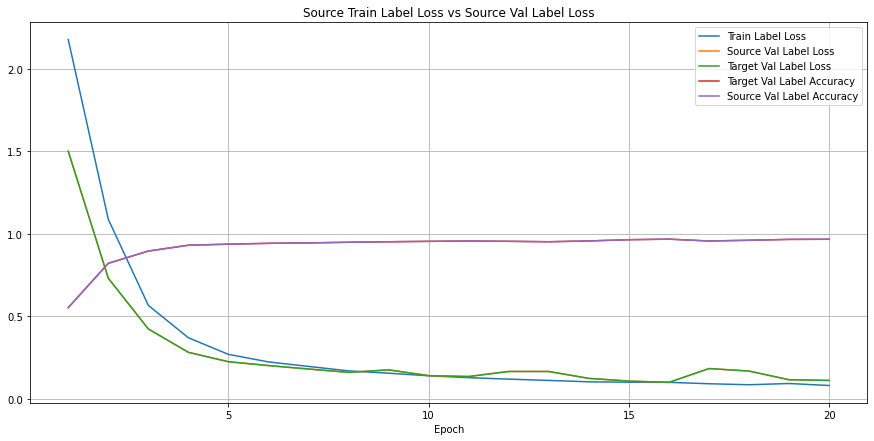

In [16]:
get_loss_curve(experiment)

<AxesSubplot:title={'center':'Results'}>

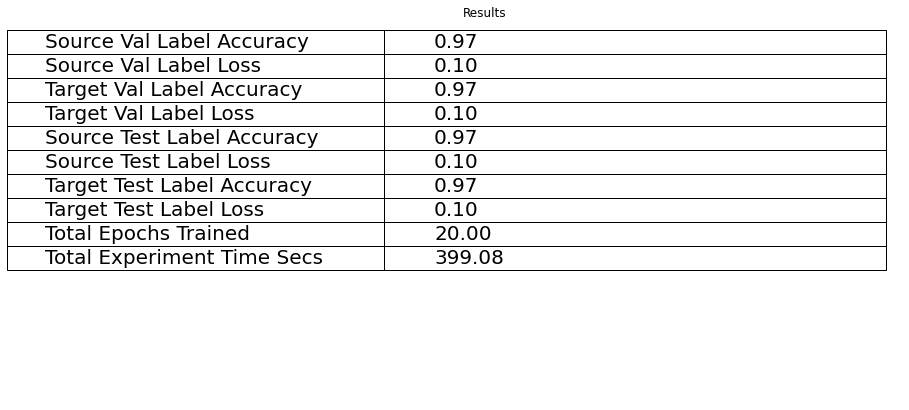

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Accuracy'}, xlabel='domain'>

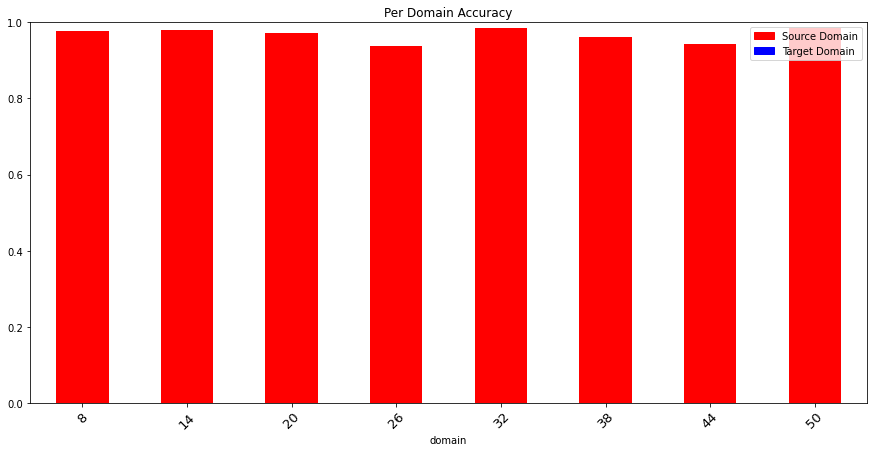

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.96859375 Target Test Label Accuracy: 0.96859375
Source Val Label Accuracy: 0.9680989583333334 Target Val Label Accuracy: 0.9680989583333334


In [20]:
json.dumps(experiment)

'{"experiment_name": "cnn_2:oracle.run2.framed", "parameters": {"experiment_name": "cnn_2:oracle.run2.framed", "labels": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "domains_source": [8, 32, 50, 14, 20, 26, 38, 44], "domains_target": [8, 32, 50, 14, 20, 26, 38, 44], "pickle_name_source": "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl", "pickle_name_target": "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl", "device": "cuda", "lr": 0.0001, "batch_size": 128, "normalize_source": false, "normalize_target": false, "num_examples_per_domain_per_label_source": -1, "num_examples_per_domain_per_label_target": -1, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_ch